# DCT (Discrete Cosine Transform) Implementation Ways

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




> **1. WAY** https://www.tutorialspoint.com/how-to-find-discrete-cosine-transform-of-an-image-using-opencv-python



In [ ]:
# import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt


# read input image as grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/catsdogs/train/cats/cat.100.jpg', 0)

print(type(img))
# convert the grayscale to float32
imf = np.float32(img) # float conversion
print(type(imf))

# find discrete cosine transform
dst = cv2.dct(imf, cv2.DCT_INVERSE)
print(type(dst))

# apply inverse discrete cosine transform
img1 = cv2.idct(dst)
print(type(img1))

# convert to uint8
img1 = np.uint8(img)
print(type(img1))

# get width and height
height, width = img1.shape[:2]
  
# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
The height of the image is:  499
The width of the image is:  403
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
The height of the image is:  499
The width of the image is:  403


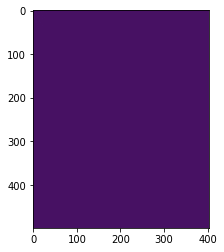

In [ ]:
# display the images
plt.imshow(dst)

True

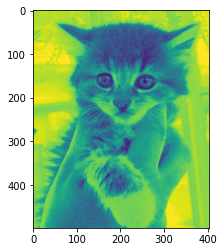

In [ ]:
plt.imshow(img1)
cv2.imwrite("/content/drive/MyDrive/Colab Notebooks/output/dct.cat.100.jpg",img1)



> **2.WAY** https://github.com/umardx/jpeg-dct-encode/blob/master/JPEG-Encoding-Decoding.ipynb



In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.colors import Normalize

# write arr to excel
def write_xlsx(arr, path):
    return pd.DataFrame(arr).to_excel(path)

# load img as arr
def load_img(img):
    return cv2.imread(img)

# convert rgb to yub
def rgb2yuv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Split channel
def split_channel(img):
    return cv2.split(img)

# Get scale alpha
def get_Q(q_jpeg):
    QTable = np.array([[16,11,10,16, 24,40, 51, 61],
                   [12,12,14,19, 26,48, 60, 55],
                   [14,13,16,24, 40,57, 69, 56],
                   [14,17,22,29, 51,87, 80, 62],
                   [18,22,37,56, 68,109,103,77],
                   [24,35,55,64, 81,104,113,92],
                   [49,64,78,87,103,121,120,101],
                   [72,92,95,98,112,100,103,99]])
    
    if q_jpeg < 50 and q_jpeg > 1:
        alpha = np.floor(5000.0/q_jpeg)
        Q = QTable*alpha
    elif q_jpeg < 100:
        alpha = np.floor(200 - 2*q_jpeg)
        Q = QTable*alpha
    elif q_jpeg == 100:
        Q = np.ones((8, 8))
    else:
        raise AttributeError("Quality Factor must be in the range [1..100]")
    return Q

def get_mse(prediction, target):
    return np.sqrt(((prediction-target)**2).mean())

def get_psnr(mse):
    return 20*np.log10(255/np.sqrt(mse))

def demo(qf, source):
    QF = qf

    # Init block 8x8
    block = 8
    h, w = np.array(source.shape[:2])/block*block
    h, w = int(h), int(w)
    source = source[:h, :w]

    blocksV = int(h/block)
    blocksH = int(w/block)
    vis0 = np.zeros((h, w), np.float32)
    result = np.zeros((h, w), np.float32)
    vis0[:h, :w] = source

    Q = get_Q(QF)
    print('q_JPEG: ', QF)
    print('\nmatrix Q_Y*alpha:\n', Q)

    # Perform DCT 8x8
    for row in range(blocksV):
        for col in range(blocksH):
            current_block = vis0[row*block:(row+1)*block, col*block:(col+1)*block]
            dct = cv2.dct(current_block)
            if row==0 and col==0:
                print('\nfirst block 8x8 of DCT(source) lossless:\n', np.round(dct).astype(int))
            result_ = np.round(dct/Q).astype(int)
            result[row*block:(row+1)*block, col*block:(col+1)*block] = result_

    # Write source, and result DCT as result_DCT.jpg
    cv2.imwrite("./content/drive/MyDrive/Colab Notebooks/output/result_DCT_{}.jpg".format(QF), np.hstack([y, result]))
    # Write array of result DCT to excel
    write_xlsx(result, "/content/drive/MyDrive/Colab Notebooks/output/result_DCT_{}.xlsx".format(QF))

    # Convert back use IDCT
    back = np.zeros((h, w), np.float32)
    for row in range(blocksV):
        for col in range(blocksH):
            current_block = result[row*block:(row+1)*block, col*block:(col+1)*block]
            idct = cv2.idct(current_block*Q)
            back[row*block:(row+1)*block, col*block:(col+1)*block] = np.round(idct).astype(int)
            if row==0 and col==0:
                print('\nfirst block 8x8 of IDCT(source) lossy:\n', np.round(idct).astype(int))

    cv2.imwrite("/content/drive/MyDrive/Colab Notebooks/output/result_IDCT_{}.jpg".format(QF), np.hstack([y, result, back]))
    cv2.imwrite("/content/drive/MyDrive/Colab Notebooks/output/rresult_{}.jpg".format(QF),back)
    mse = get_mse(back, y)
    psnr = np.round(get_psnr(mse), 2)
    print('\nPSNR (QF={}) : {} dB'.format(QF, psnr))
    print('\nOpen file : /content/drive/MyDrive/Colab Notebooks/output/result_IDCT_{}.jpg\n'.format(QF))

In [ ]:
# Load source.jpg
source = load_img('/content/drive/MyDrive/Colab Notebooks/catsdogs/train/cats/cat.100.jpg')
# convert source.jpg to YUV Channel
yuv = rgb2yuv(source)
# split YUV channel
y, u, v = split_channel(yuv)
# Write array of Y to excel
write_xlsx(y, "/content/drive/MyDrive/Colab Notebooks/output/Y_Channel.xlsx")

In [ ]:
# Perform DCT with Y Channel as source
np.set_printoptions(precision=4, suppress=True)
source = y

QFs = [100.0, 99.0, 98.0, 96.0, 94.0, 92.0]

for qf in QFs:
    print('For QF : ', qf)
    demo(qf, source)
    print('=====================================\n\n\n\n\n')

For QF :  100.0
q_JPEG:  100.0

matrix Q_Y*alpha:
 [[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]

first block 8x8 of DCT(source) lossless:
 [[1774   -7   -1    0    0    0    0    0]
 [   7    0    0    1    0    0    0    0]
 [   0    9    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0   -1    0    0]]

first block 8x8 of IDCT(source) lossy:
 [[224 224 223 223 223 223 222 222]
 [222 222 223 223 223 223 223 223]
 [220 221 221 222 223 224 224 224]
 [219 219 220 222 223 224 225 225]
 [218 219 220 221 222 223 224 225]
 [219 219 220 221 221 222 223 223]
 [220 220 221 221 221 221 221 221]
 [221 221 221 221 220 220 220 220]]

PSNR (QF=100.0) : 34.



> **3.WAY** https://github.com/machingclee/2022-07-07-discrete-cosine-transform/blob/main/DCT.ipynb



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
%matplotlib inline

In [ ]:
N = 8
IMAGE_PATH = "/content/drive/MyDrive/Colab Notebooks/catsdogs/train/cats/cat.100.jpg"

In [ ]:
def range2D(n):
  indexes = []
  for i in range(0, n):
    for j in range(0, n):
      indexes.append((i, j))
  return indexes

def alpha(p):
  return 1/np.sqrt(N) if p == 0 else np.sqrt(2/N)

def cos_basis(i,j):
  def cal_result(a):
    x=a[0]
    y=a[1]
    
    return alpha(i) * alpha(j) * np.cos((2*x+1) * i * np.pi/(2*N)) *  np.cos((2*y+1) * j * np.pi/(2*N)) 
  return cal_result

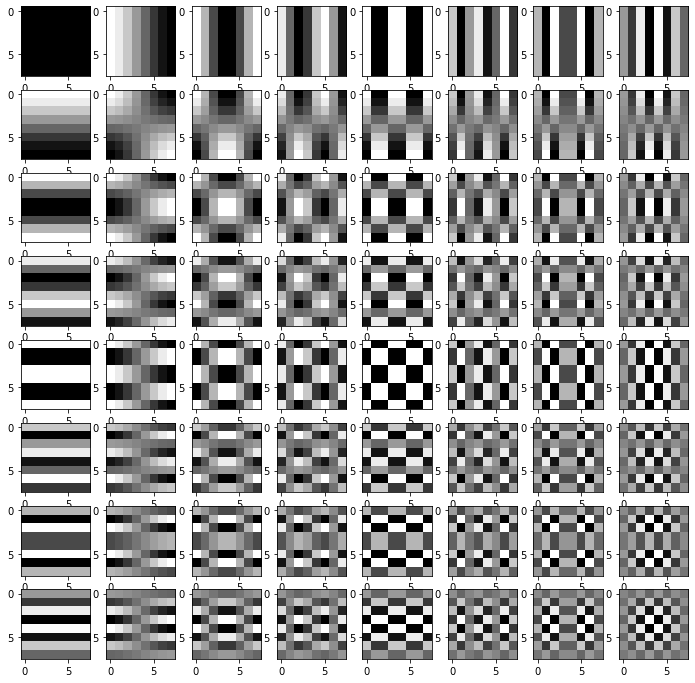

In [ ]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)
xy_range = range2D(N)
xy_plane_NxN = (np.array(xy_range).reshape(N,N,2))

for i in range(0, N):
  for j in range(0, N):
    xy_result = np.apply_along_axis(cos_basis(i,j), -1, xy_plane_NxN)
    plt.subplot(N, N, 1+ N*i + j)
    plt.imshow(xy_result, cmap="gray")

In [ ]:
xy_result = np.apply_along_axis(cos_basis(0,0), -1, xy_plane_NxN)
print(xy_result)

[[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]]


In [ ]:
U = np.zeros((N,N))

for i in range(0, N):
  for j in range(0, N):
    U[i, j] = alpha(j) * np.cos((2*i+1)*j*np.pi/(2*N))

U_t =  U.transpose()

np.matmul(U, U_t) # indeed identity 

array([[ 1., -0., -0., -0., -0.,  0.,  0., -0.],
       [-0.,  1.,  0.,  0.,  0., -0., -0.,  0.],
       [-0.,  0.,  1., -0., -0., -0., -0., -0.],
       [-0.,  0., -0.,  1.,  0.,  0.,  0.,  0.],
       [-0.,  0., -0.,  0.,  1., -0., -0., -0.],
       [ 0., -0., -0.,  0., -0.,  1.,  0.,  0.],
       [ 0., -0., -0.,  0., -0.,  0.,  1.,  0.],
       [-0.,  0., -0.,  0., -0.,  0.,  0.,  1.]])

In [ ]:
def create_mask(closure):
  mask = np.zeros((N, N))
  for i in range(N):
    for j in range(N):
      if closure(i,j):
        mask[i, j] = 1
  return mask

original = load_img(IMAGE_PATH, target_size=(512, 512), color_mode="grayscale")
original = img_to_array(original).astype("uint8")
original = np.squeeze(original)
original.shape

(512, 512)

[[0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


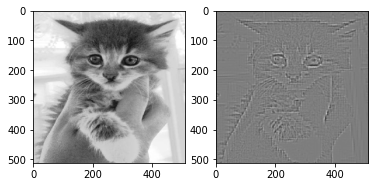

In [ ]:
mask = create_mask(lambda i,j: 1<=i+j<=3)
print(mask)
steps = int(original.shape[0]/N) # we choose 512x512 image, there fore steps = 64
compressed = np.zeros_like(original)

for x in range(steps):
  for y in range(steps):
    sub_pixels = original[N * y: N*(y+1), N * x: N*(x+1)]
    sub_pixels = sub_pixels - 127.5
    fourier_coefficients = np.matmul(np.matmul(U_t, sub_pixels), U)
    fourier_coefficients = fourier_coefficients * mask 
    reverted_pixels = np.matmul(np.matmul(U, fourier_coefficients), U_t)
    reverted_pixels = reverted_pixels + 127.5
    compressed[N * y: N*(y+1), N * x: N*(x+1)] = reverted_pixels
    
fig.set_figheight(20)
fig.set_figwidth(20)
plt.subplot(1, 2, 1)
plt.imshow(original, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(compressed, cmap="gray")
plt.savefig("DCT_result", dpi=200, bbox_inches="tight")

In [ ]:
compressed

array([[129, 129, 129, ..., 132, 132, 132],
       [128, 128, 128, ..., 133, 134, 134],
       [126, 126, 126, ..., 135, 135, 135],
       ...,
       [132, 132, 130, ..., 128, 127, 127],
       [131, 131, 130, ..., 128, 128, 127],
       [131, 130, 129, ..., 128, 128, 127]], dtype=uint8)